# Save figures for publication
Author: Pia Rautenstrauch

Date: 2024-01-22

Abbreviation for Competition use case mosaic: CU_mosaic 


## Requirements
- [x] Fontsize: > 7 - 12
- [x] font: Arial
- [x] dpi: 600


## Other modifications
- [x] random order of plotting of colors in umap (https://github.com/scverse/scanpy/issues/891)

Anaconda environment: scib_v1.0.1_min

On max005.

In [1]:
# Imports
import os
import anndata as ad
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import scib
import scanpy as sc
import seaborn as sns
from sklearn.metrics import silhouette_score, silhouette_samples
from matplotlib import rc

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
scib.__version__

'1.0.1'

In [4]:
# From https://matplotlib.org/stable/gallery/subplots_axes_and_figures/figure_size_units.html
px = 1/plt.rcParams['figure.dpi']  # pixel in inches

In [5]:
sc.set_figure_params(dpi_save=600, dpi=80, transparent=True, format='png', fontsize=9, figsize=(200*px, 140*px))

In [6]:
plt.rcParams['figure.figsize']

[2.7777777777777777, 1.9444444444444444]

In [7]:
# overwrite scanpy/matplotlib default font: chose: Arial

In [8]:
# Need to remove chached fonts

In [9]:
! rm ~/.cache/matplotlib -rf

In [10]:
font_dirs = ["miniconda3/envs/scib_v1.0.1_min/fonts"]  # The path to the custom font file.
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)



In [11]:
# change font
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "Arial"

In [12]:
plt.rcParams['lines.markersize'] = 3.0

In [13]:
# List of identifiers of trained models
models = []

seeds = [11]

for use_case in ['mosaic_b']:
    for seed in seeds:
        model = 'liam_{}_seed_{}'.format(use_case, seed)
        models += [model]
        
for use_case in ['mosaic_b']: 
    for seed in seeds:
        model = 'MultiVI_{}_seed_{}'.format(use_case, seed)
        models += [model]


In [14]:
# Unify color scheme
color_dict = {
 'atac': '#88CCEE',
 'gex': '#882255',
 'paired': '#CC6677',
 's1': '#0173b2',
 's2': '#de8f05',
 's3': '#029e73',
 's4': '#d55e00',
 'B1 B': '#023fa5ff',
 'CD14+ Mono': '#7d87b9ff',
 'CD16+ Mono': '#bec1d4ff',
 'CD4+ T activated': '#d6bcc0ff',
 'CD4+ T naive': '#bb7784ff',
 'CD8+ T': '#8e063bff',
 'CD8+ T naive': '#4a6fe3ff',
 'cDC2': '#8595e1ff',
 'Erythroblast': '#b5bbe3ff',
 'G/M prog': '#e6afb9ff',
 'HSC': '#e07b91ff',
 'ID2-hi myeloid prog': '#d33f6aff',
 'ILC': '#11c638ff',
 'Lymph prog': '#8dd593ff',
 'MK/E prog': '#c6dec7ff',
 'Naive CD20+ B': '#ead3c6ff',
 'NK': '#f0b98dff',
 'Normoblast': '#ef9708ff',
 'pDC': '#0fcfc0ff',
 'Plasma cell': '#9cded6ff',
 'Proerythroblast': '#d5eae7ff',
 'Transitional B': '#f3e1ebff',
 's1d1': '#1f77b4ff',
 's1d2': '#ff7f0eff',
 's1d3': '#279e68ff',
 's2d1': '#d62728ff',
 's2d4': '#aa40fcff',
 's2d5': '#8c564bff',
 's3d10': '#e377c2ff',
 's3d3': '#b5bd61ff',
 's3d6': '#17becfff',
 's3d7': '#aec7e8ff',
 's4d1': '#ffbb78ff',
 's4d8': '#98df8aff',
 's4d9': '#ff9896ff'}

In [15]:
def plot_umaps(models):
    # Collect computed scores, nested dict is simple to convert to pd.DataFrame
    for model in models:
        np.random.seed(61)

        # Read embeddings
        embedding = ad.read_h5ad("./../Predictions/{}.prediction.h5ad".format(model))

        # Remove _paired suffix (from MultiVI models)
        if "MultiVI" in model:
            embedding.obs.index = embedding.obs.index.map(lambda x: x.split('_')[0])

        embedding.obsm['X_emb'] = embedding.X.copy()

        # Compute neighbors 
        sc.pp.neighbors(embedding, use_rep='X_emb')
        sc.tl.umap(embedding)

        # Load metadata (cell type information, etc.)
        solution = ad.read_h5ad("./../../../data/original/neurips_competition/openproblems_bmmc_multiome_phase2/openproblems_bmmc_multiome_phase2.censor_dataset.output_solution.h5ad")

        # Make sure order is the same as for the embedding
        solution = solution[embedding.obs.index,:].copy()

        # Transfer batch information and cell type labels to embedding as done for neurips evaluation
        embedding.obs['sample'] = solution.obs['batch']
        embedding.obs['site'] = solution.obs['batch'].apply(lambda x: x.split("d")[0])
        embedding.obs['donor'] = solution.obs['batch'].apply(lambda x: x.split("d")[1])
        embedding.obs['cell type'] = solution.obs['cell_type']

        # make sure these variables are categorical
        embedding.obs['sample'] = embedding.obs['sample'].astype('category')
        embedding.obs['site'] = embedding.obs['site'].astype('category')
        embedding.obs['donor'] = embedding.obs['donor'].astype('category')
        embedding.obs['cell type'] = embedding.obs['cell type'].astype('category')

        # random plotting order
        embedding = sc.pp.subsample(embedding, fraction=1., copy=True)

        ### Save UMAP visualization as png 
        sc.pl.umap(
            embedding,
            color=['cell type', 'mod'],
            size=1,
            frameon=False,
            ncols=1,
            wspace=-0.2,
            palette=color_dict,
            save="_{}_CU_mosaic.png".format(model),
            legend_loc=None,
            title=['', '']
            #legend_fontsize='x-small'
        )

    ### Save UMAP visualization as png 
    sc.pl.umap(
            embedding,
            color=['cell type', 'mod'],
            size=1,
            frameon=False,
            ncols=1,
            wspace=-0.2,
            palette=color_dict,
            save="_{}_CU_mosaic_legend.png".format(model),
            legend_fontsize='x-small',
            title=['','']
    )




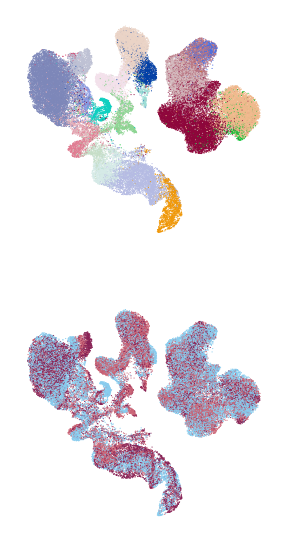

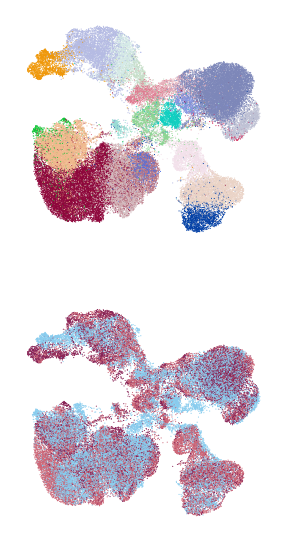

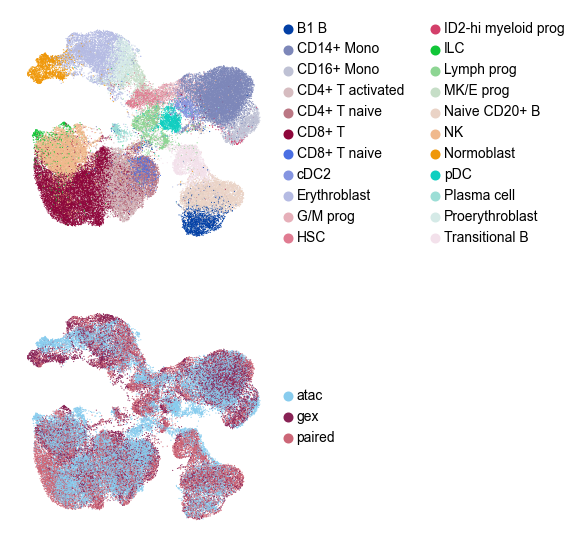

In [16]:
plot_umaps(models)

In [17]:
# List of identifiers of trained models
models = []

seeds = [11]

for use_case in ['mosaic_full']:
    for seed in seeds:
        model = 'liam_{}_seed_{}'.format(use_case, seed)
        models += [model]
        
for use_case in ['mosaic_full']: 
    for seed in seeds:
        model = 'MultiVI_{}_seed_{}'.format(use_case, seed)
        models += [model]


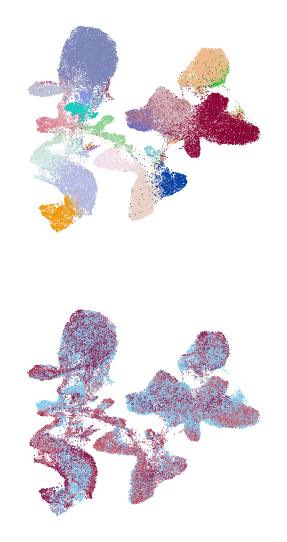

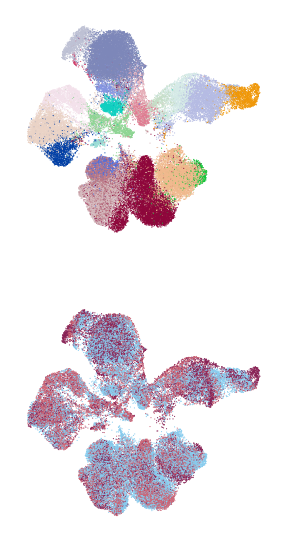

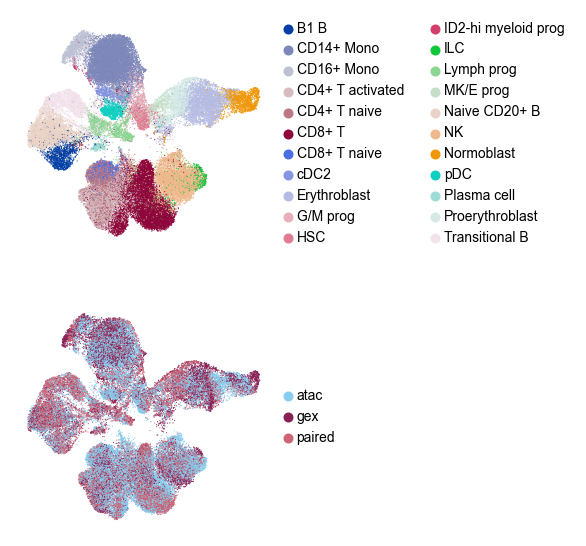

In [18]:
plot_umaps(models)

In [19]:
# List of identifiers of trained models
models = []

seeds = [11]

for use_case in ['mosaic_a']:
    for seed in seeds:
        model = 'liam_{}_seed_{}'.format(use_case, seed)
        models += [model]
        
for use_case in ['mosaic_a']: 
    for seed in seeds:
        model = 'MultiVI_{}_seed_{}'.format(use_case, seed)
        models += [model]


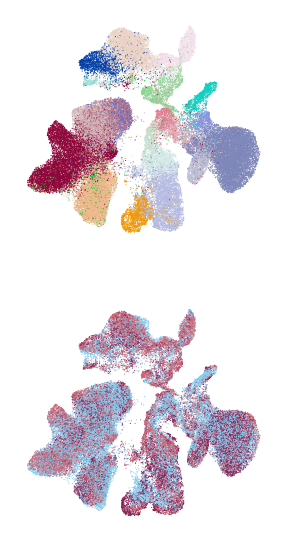

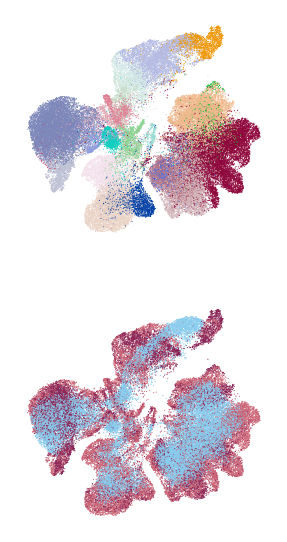

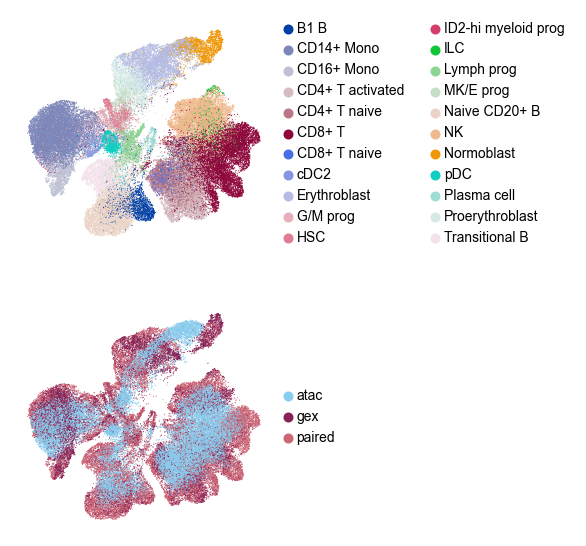

In [20]:
plot_umaps(models)